In [1]:
%matplotlib inline
from pycocotools.coco import COCO
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import os
import pylab
import skimage.io as io
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (8.0, 10.0)


C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
images_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/val2017'
anns_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/annotations/instances_val2017.json'
processed_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/processed/val2017_P"


In [3]:
coco = COCO(anns_dir)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [4]:
# Get image IDs and corresponding annotations for validation set
image_ids = coco.getImgIds()
annotations = coco.loadAnns(coco.getAnnIds(image_ids))


In [5]:
target_shape = (416, 416)

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Split the data into training and validation sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)


In [175]:
train_anns = coco.loadAnns(coco.getAnnIds(train_ids))
test_anns = coco.loadAnns(coco.getAnnIds(test_ids))
val_anns = coco.loadAnns(coco.getAnnIds(val_ids))

In [7]:
def load_image_set(image_ids, image_dir, coco):
    img_set = []
    
    for img_id in tqdm(image_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        image = cv2.imread(img_path)

        img_set.append(image)
        
    return img_set


In [8]:
train_images = load_image_set(train_ids, processed_dir, coco)
val_images = load_image_set(val_ids, processed_dir, coco)
test_images = load_image_set(test_ids, processed_dir, coco)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.40it/s]


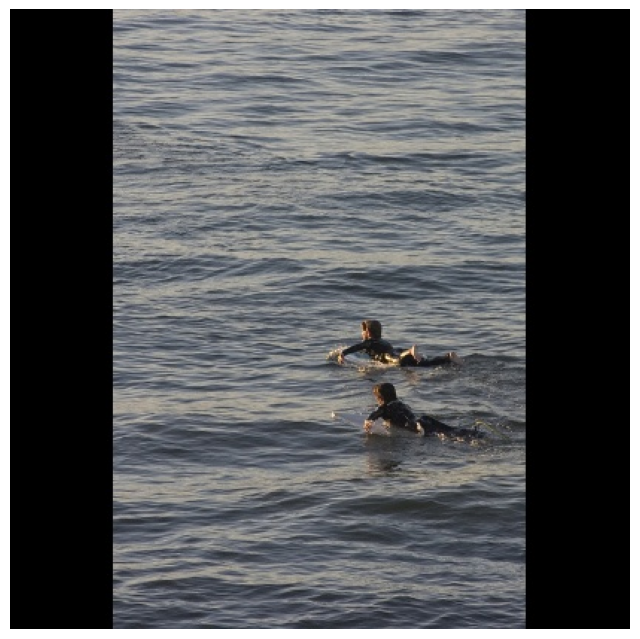

In [9]:
# Display one image using matplotlib
plt.imshow(cv2.cvtColor(train_images[7], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()


In [247]:
# Get the number of classes
categories = coco.loadCats(coco.getCatIds())
num_classes = len(categories)
num_classes = 90


In [124]:
def image_anns_groups(img_ids, annotations):
    images_anns = []
    
    for img in tqdm(img_ids):
        anns = [annotation for annotation in annotations if annotation['image_id'] == img]
        pair = img, anns
        images_anns.append(pair)
    
    return images_anns


In [180]:
def process_bbox(annotation):
    # Original bounding box coordinates
    x, y, width, height = (
        annotation["bbox"][0],
        annotation["bbox"][1],
        annotation["bbox"][2],
        annotation["bbox"][3],
    )
    
    # Ensure non-zero width and height
    width = max(width, 1)
    height = max(height, 1)

    target_width, target_height = 416, 416

    # Adjust coordinates based on original and target image sizes
    x_ratio = target_width / x if x != 0 else 1
    y_ratio = target_height / y if y != 0 else 1

    adjusted_x = x * x_ratio
    adjusted_y = y * y_ratio
    adjusted_width = width * x_ratio
    adjusted_height = height * y_ratio
    
    # Convert to YOLO format (center_x, center_y, width, height)
    center_x = (adjusted_x + adjusted_width / 2) / target_width
    center_y = (adjusted_y + adjusted_height / 2) / target_height
    normalized_width = adjusted_width / target_width
    normalized_height = adjusted_height / target_height
    
    processed_bbox = center_x, center_y, adjusted_width, adjusted_height
    
    return processed_bbox


def yolo_bbox(bbox, grid_size):
    x, y, width, height = bbox

    # Normalize coordinates to range [0, 1] within the grid cell
    x_normalized = x * grid_size - int(x * grid_size)
    y_normalized = y * grid_size - int(y * grid_size)
    width_normalized = width
    height_normalized = height

    return x_normalized, y_normalized, width_normalized, height_normalized


In [245]:
def yolo_target_labels(annotations, grid_size, num_classes):
    target_labels = []

    for annotation in annotations:
        class_id = annotation['category_id']
        bbox = yolo_bbox(process_bbox(annotation), grid_size)
        x, y, width, height = bbox

        # Create the target label
        target_label = [
            0,  # Objectness score (1 for object presence, 0 for no object)
            x,
            y,
            width,
            height,
        ]

        # Class probabilities
        class_probabilities = np.zeros(num_classes)
        class_probabilities[class_id - 1] = 1  # Set the class probability for the specific class_id
        target_label.extend(class_probabilities)

        # Check if the object is present in the current grid cell
        grid_x = int(x * grid_size)
        grid_y = int(y * grid_size)
        if grid_x == int(x * grid_size) and grid_y == int(y * grid_size):
            target_label[0] = 1  # Set objectness score to 1

        target_labels.append(target_label)

    return target_labels


In [236]:
# Load annotations for each set
train_anns = coco.loadAnns(coco.getAnnIds(train_ids))
test_anns = coco.loadAnns(coco.getAnnIds(test_ids))
val_anns = coco.loadAnns(coco.getAnnIds(val_ids))


In [262]:
# Process annotations to get target labels for each set
grid_size = 13
train_T_labels = yolo_target_labels( train_anns, 13, num_classes)
test_T_labels = yolo_target_labels(test_anns, 13, num_classes)
val_T_labels = yolo_target_labels(val_anns, 13, num_classes)


In [243]:
def find_max_min_category_ids(annotations):
    max_category_id = float('-inf')
    min_category_id = float('inf')

    for annotation in annotations:
        category_id = annotation['category_id']

        if category_id > max_category_id:
            max_category_id = category_id

        if category_id < min_category_id:
            min_category_id = category_id

    return max_category_id, min_category_id

In [244]:
max_category_id, min_category_id = find_max_min_category_ids(train_anns)
print("Max Category ID:", max_category_id)
print("Min Category ID:", min_category_id)


Max Category ID: 90
Min Category ID: 1


In [251]:
train_img_anns[27]
train_T_labels[1750]
#ann = [annotation for annotation in annotations if annotation['image_id'] == 463730]
#ann

[1,
 0.28412903225806474,
 0.49447791164658383,
 274.18425806451614,
 95.64658634538152,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [201]:
# Create a new list to store expanded samples
expanded_samples = []

for i, (image_filename, annotation) in enumerate(zip(image_filenames, annotations)):
    # Process the annotation and create target labels
    target_labels = yolo_target_labels([annotation], grid_size, num_classes)

    # Create a duplicate entry for each annotation
    for label in target_labels:
        expanded_samples.append({
            'image_filename': image_filename,
            'target_label': label,
        })

NameError: name 'image_filenames' is not defined

In [215]:
def data_generator(img_samples, target_labels, batch_size):
    num_samples = len(img_samples)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_samples = [img_samples[idx] for idx in batch_indices]
            batch_labels = [target_labels[idx] for idx in batch_indices]
            
            # Print shapes for debugging
            print("Batch Samples Shape:", np.array(batch_samples).shape)
            print("Batch Labels Shape:", np.array(batch_labels).shape)

            yield tf.convert_to_tensor(np.array(batch_samples)), tf.convert_to_tensor(np.array(batch_labels))

In [196]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def convolutional_block(x, filters, size, strides=(1, 1)):
    x = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(x, filters):
    short_cut = x
    x = convolutional_block(x, filters // 2, 1)
    x = convolutional_block(x, filters // 2, 3)
    short_cut = convolutional_block(short_cut, filters // 2, 1)
    x = layers.Add()([short_cut, x])
    return x

def yolo_v3(input_size, num_classes, num_anchors):
    input_image = layers.Input(shape=(input_size, input_size, 3))

    x = convolutional_block(input_image, 32, 3)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = convolutional_block(x, 64, 3)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(2):
        x = residual_block(x, 64)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 128)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 256)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    for _ in range(4):
        x = residual_block(x, 512)

    for _ in range(2):
        x = residual_block(x, 1024)

    # Adjust the number of output channels based on the number of anchors and classes
    output_channels = num_anchors * (4 + 1 + num_classes)
    output = layers.Conv2D(output_channels, 1, activation='sigmoid')(x)

    model = Model(inputs=input_image, outputs=output)
    return model


In [264]:
import tensorflow as tf
from keras import backend as K

def yolo_loss(grid_size, num_boxes, num_classes):
    def loss_function(y_true, y_pred):
        # Extract components from predictions and targets
        true_objectness = y_true[..., 4]  # Binary indicator for object presence
        pred_objectness = y_pred[..., 4]

        true_box = y_true[..., :4]  # Ground truth bounding box coordinates
        pred_box = y_pred[..., :4]

        true_class = y_true[..., 5:]  # Ground truth class probabilities
        true_class = tf.cast(true_class, dtype=tf.uint8)
        true_class = tf.one_hot(true_class, num_classes)
        pred_class = y_pred[..., 5:]

        # Compute individual loss components
        objectness_loss = tf.keras.losses.BinaryCrossentropy()(true_objectness, pred_objectness)
        box_loss = tf.keras.losses.MeanSquaredError()(true_objectness * true_box, true_objectness * pred_box)
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)

        # Combine the losses with appropriate weights
        total_loss = objectness_loss + 5.0 * box_loss + 2.0 * class_loss

        return total_loss

    return loss_function


In [198]:
input_size = target_shape[0]
num_anchors = 5

In [205]:
yolo_model = yolo_v3(input_size, num_classes, 5)

In [208]:
yolo_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d_255 (Conv2D)         (None, 416, 416, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_250 (B  (None, 416, 416, 32)         128       ['conv2d_255[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_250 (LeakyReLU  (None, 416, 416, 32)         0         ['batch_normalization_25

                                                                                                  
 conv2d_263 (Conv2D)         (None, 52, 52, 64)           2048      ['max_pooling2d_27[0][0]']    
                                                                                                  
 batch_normalization_258 (B  (None, 52, 52, 64)           256       ['conv2d_263[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_258 (LeakyReLU  (None, 52, 52, 64)           0         ['batch_normalization_258[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_265 (Conv2D)         (None, 52, 52, 64)           2048      ['max_pooling2d_27[0][0]']    
          

                                                                                                  
 batch_normalization_267 (B  (None, 52, 52, 64)           256       ['conv2d_272[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_267 (LeakyReLU  (None, 52, 52, 64)           0         ['batch_normalization_267[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_274 (Conv2D)         (None, 52, 52, 64)           4096      ['add_84[0][0]']              
                                                                                                  
 conv2d_273 (Conv2D)         (None, 52, 52, 64)           36864     ['leaky_re_lu_267[0][0]']     
          

 conv2d_281 (Conv2D)         (None, 26, 26, 128)          16384     ['add_87[0][0]']              
                                                                                                  
 batch_normalization_276 (B  (None, 26, 26, 128)          512       ['conv2d_281[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_276 (LeakyReLU  (None, 26, 26, 128)          0         ['batch_normalization_276[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_283 (Conv2D)         (None, 26, 26, 128)          16384     ['add_87[0][0]']              
                                                                                                  
 conv2d_28

                                                                                                  
 conv2d_290 (Conv2D)         (None, 13, 13, 256)          65536     ['add_90[0][0]']              
                                                                                                  
 batch_normalization_285 (B  (None, 13, 13, 256)          1024      ['conv2d_290[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_285 (LeakyReLU  (None, 13, 13, 256)          0         ['batch_normalization_285[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_292 (Conv2D)         (None, 13, 13, 256)          65536     ['add_90[0][0]']              
          

                                                                                                  
 batch_normalization_294 (B  (None, 13, 13, 512)          2048      ['conv2d_299[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_294 (LeakyReLU  (None, 13, 13, 512)          0         ['batch_normalization_294[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_301 (Conv2D)         (None, 13, 13, 512)          131072    ['add_93[0][0]']              
                                                                                                  
 conv2d_300 (Conv2D)         (None, 13, 13, 512)          2359296   ['leaky_re_lu_294[0][0]']     
          

In [255]:
# Create data generators for training, testing, and validation sets
batch_size = 32

def data_generator(img_samples, target_labels, batch_size):
    num_samples = len(img_samples)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_samples = [img_samples[idx] for idx in batch_indices]
            batch_labels = [target_labels[idx] for idx in batch_indices]
            
            # Print shapes for debugging
            print("Batch Samples Shape:", np.array(batch_samples).shape)
            print("Batch Labels Shape:", np.array(batch_labels).shape)

            yield np.array(batch_samples), np.array(batch_labels)

# Create data generators for each set
train_data_generator = data_generator(train_images, train_T_labels, batch_size)
test_data_generator = data_generator(test_images, test_T_labels, batch_size)
val_data_generator = data_generator(val_images, val_T_labels, batch_size)

# Train the model
yolo_model.fit(
    x=train_data_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_images) // batch_size
)


Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 95)
Epoch 1/10


ValueError: in user code:

    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\1039793597.py", line 19, in loss_function  *
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 420) are incompatible


In [267]:
train_T_labels = np.array(train_T_labels)
test_T_labels = np.array(test_T_labels)
val_T_labels = np.array(val_T_labels)

print("Shape before reshape:", train_T_labels.shape)
print("Size before reshape:", train_T_labels.size)

# Now you can reshape them
train_T_labels = train_T_labels.reshape((32, 13, 13, 95))
test_T_labels = test_T_labels.reshape((32, 13, 13, 95))
val_T_labels = val_T_labels.reshape((32, 13, 13, 95))

Shape before reshape: (23016, 95)
Size before reshape: 2186520


ValueError: cannot reshape array of size 2186520 into shape (32,416,416,95)

In [260]:
len(train_T_labels)

23016

In [265]:
yolo_model.compile(optimizer='adam', loss=yolo_loss(grid_size, num_anchors, num_classes))  # Adjust the loss function based on your task

# Train the model
batch_size = 32
num_epochs = 10

# Create data generators for each set
train_data_generator = data_generator(train_images, train_T_labels, batch_size)
test_data_generator = data_generator(test_images, test_T_labels, batch_size)
val_data_generator = data_generator(val_images, val_T_labels, batch_size)

yolo_model.fit_generator(
    generator=train_data_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_images) // batch_size
)

Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 95)
Epoch 1/10


C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\1892808027.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  yolo_model.fit_generator(


ValueError: in user code:

    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Mohamed Habib\AppData\Local\Temp\ipykernel_7924\3231569737.py", line 21, in loss_function  *
        class_loss = tf.keras.losses.CategoricalCrossentropy()(true_class, pred_class)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None, 90) and (None, None, None, 420) are incompatible


In [253]:
print("Shape of train_T_labels:", np.array(train_T_labels[0]).shape)


Shape of train_T_labels: (95,)


In [217]:
sample_batch, label_batch = next(train_data_generator)
print("Sample Batch Shape:", sample_batch.shape)
print("Label Batch Shape:", label_batch.shape)

Batch Samples Shape: (32, 416, 416, 3)
Batch Labels Shape: (32, 85)
Sample Batch Shape: (32, 416, 416, 3)
Label Batch Shape: (32, 85)
